# Projet SD-WAN-ReinforcementLearning

# Partie: Recherche opérationnelle

In [89]:
#!pip install pulp

Imports

In [205]:
import networkx as nx
import pulp
import random
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from collections import defaultdict

np.random.seed(1)

### Generation of random graph

In [206]:
def image_nertworkx(nodes = 25, edges = 3):
    g = nx.to_directed(nx.fast_gnp_random_graph(nodes,edges/nodes,directed=True))
    check_list = []
    for i, j in g.edges:
        if i not in check_list:
            check_list.append(i)
    for ii in range (nodes):
        if ii not in check_list:
            g = image_nertworkx(nodes , edges)

    
    return g

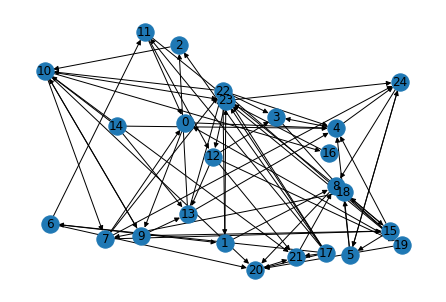

In [207]:
g = image_nertworkx()


node_pose = {}
for i in g.nodes():
    node_pose[i] = (random.uniform(1.0, 10.0),random.uniform(1.0, 10.0))

nx.draw(g,pos = node_pose, with_labels=True)
#plt.savefig("images/original.jpg")
plt.show()

### Generation of random attributes for the graph edges

In [208]:
color = {}
for i, j in g.edges:
    color[i, j] = color[j, i] = (0,0,0,0.5)
    
nx.set_edge_attributes(g, color, 'color')

In [209]:
dict_capa = {}
for i, j in g.edges:
    dict_capa[i, j] = dict_capa[j, i] = round(random.uniform(1.0, 20.0), 0)

nx.set_edge_attributes(g, dict_capa, 'capacity')

In [210]:
dict_used = {}
for i, j in g.edges:
    dict_used[i, j] = dict_used[j, i] = min(round(random.uniform(0.0, 15.0), 0),dict_capa[i, j])
    
nx.set_edge_attributes(g, dict_used, 'used')

In [211]:
dict_ratio = {}
for i, j in g.edges:
    dict_ratio[i, j] = dict_ratio[j, i] = dict_used[i, j]/dict_capa[i, j]

nx.set_edge_attributes(g, dict_ratio, 'ratio')

In [212]:
dict_delay = {}
for i, j in g.edges:
    dict_delay[i, j] = dict_delay[j, i] = round(random.uniform(1.0, 20.0), 2)

nx.set_edge_attributes(g, dict_delay, 'delay')

Calculation of variable score based on previously generated attribute "ratio"

In [213]:
big_d = {}
small_d = {}

for link in g.edges:
    small_d = {}
    small_d['Source'] = link[0]
    small_d['Ratio'] = g.edges[link]['ratio']
 
    big_d[str(link)] = small_d
temp = pd.DataFrame.from_dict(big_d,orient='index')

temp = temp.sort_values(by=['Source','Ratio'])

for i in temp.Source.unique():
    cpt=0
    for j in temp[temp['Source'] == i].index:
        cpt+=1
        temp.at[str(j),'Score'] = cpt


Have to affect it twice to get attributes value on both directions

In [214]:
for link in g.edges:
    g.edges[link]['score'] = temp.at[str(link),'Score'] 

for link in g.edges:
    if g.edges[link]['score'] != temp.at[str(link),'Score'] :
        g.edges[link]['score'] = temp.at[str(link),'Score'] 

for link in g.edges:
    if g.edges[link]['score'] != temp.at[str(link),'Score'] :
            g.edges[link]['score'] = temp.at[str(link),'Score'] 
            

### Instantiation 

In [215]:
# instantiate
list_keys = ['shortest_path','min_delay','min_banwidth_sum','min_banwidth_square_sum','min_score','min_square_score']
dict_prob = {}
dict_prob = dict_prob.fromkeys(list_keys)


nodes_models = {}

dict_res = defaultdict(dict)

In [216]:
source = 0
target = 24

In [217]:
Delay_matrice = np.zeros(shape=(25,25))
for link in g.edges:
    Delay_matrice[link] = g.edges[link]['delay']
Delay_matrice[Delay_matrice==0] = 1000
Delay_df = pd.DataFrame(Delay_matrice)
Delay_df

,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
0,1000.00,1000.00,1000.00,1000.00,18.54,1000.00,1000.00,1000.00,1000.00,1.00,...,1000.00,1000.0,1000.0,1000.00,1000.00,1000.00,1000.00,1000.00,1000.00,1000.00
1,1000.00,1000.00,1000.00,1000.00,1000.00,1000.00,1000.00,1000.00,14.22,1000.00,...,1000.00,1000.0,1000.0,1000.00,1000.00,1000.00,1000.00,1000.00,4.07,1000.00
2,1000.00,1000.00,1000.00,1000.00,1000.00,1000.00,1000.00,1000.00,1000.00,1000.00,...,1000.00,1000.0,1000.0,1000.00,1000.00,1000.00,1000.00,1000.00,1000.00,1000.00
3,1000.00,1000.00,1000.00,1000.00,1000.00,1000.00,1000.00,1000.00,1000.00,1000.00,...,1000.00,1000.0,1000.0,14.66,1000.00,1000.00,1000.00,1000.00,1000.00,1000.00
4,1000.00,1000.00,1000.00,11.16,1000.00,1000.00,1000.00,1000.00,1000.00,1000.00,...,1000.00,1000.0,1000.0,1000.00,1000.00,1000.00,1000.00,1000.00,1000.00,10.91
5,1000.00,1000.00,1000.00,1000.00,5.79,1000.00,1000.00,1000.00,1000.00,1000.00,...,1000.00,1000.0,1000.0,6.12,1000.00,1000.00,1000.00,1000.00,1000.00,2.70
6,1000.00,9.37,1000.00,1000.00,1000.00,1000.00,1000.00,1000.00,1000.00,1000.00,...,1000.00,1000.0,1000.0,1000.00,1000.00,12.47,1000.00,1000.00,1000.00,1000.00
7,17.14,1000.00,1000.00,1000.00,1000.00,1000.00,1000.00,1000.00,1000.00,1000.00,...,9.72,1000.0,1000.0,1000.00,1000.00,1000.00,1000.00,2.94,1000.00,16.82
8,1000.00,1000.00,1000.00,1000.00,1000.00,1000.00,1000.00,1000.00,1000.00,1000.00,...,1000.00,1000.0,1000.0,1000.00,10.93,2.01,1000.00,1000.00,1000.00,1000.00
9,1000.00,1000.00,1000.00,1000.00,1000.00,1000.00,1000.00,1000.00,1000.00,1000.00,...,14.56,1000.0,1000.0,1000.00,1000.00,1000.00,1000.00,1000.00,1000.00,1000.00


In [218]:


Delay_df = pd.DataFrame(np.zeros((1,1)))
for link in g.edges:
    s_link = str(link).strip('(').strip(')').replace(',','_').replace(' ','')
    Delay_df[s_link] = g.edges[link]['delay']
Delay_df

,0,0_4,0_9,1_8,1_23,2_10,3_18,4_3,4_24,5_4,...,21_8,22_1,22_3,22_4,22_10,22_19,23_12,23_24,24_5,24_8
0,0.0,18.54,1.0,14.22,4.07,18.38,14.66,11.16,10.91,5.79,...,18.73,15.08,12.01,17.62,1.08,8.64,17.6,3.66,2.7,8.92


In [219]:
def new_iter_delay(Delay_df,action_taken, bdw):
    New_iter = pd.DataFrame(np.zeros((1,1)))
    iter = Delay_df.iloc[-1,0]+1
    for link in g.edges:
        s_link = str(link).strip('(').strip(')').replace(',','_').replace(' ','')
        action_taken = str(action_taken).strip('(').strip(')').replace(',','_').replace(' ','')
        if action_taken != s_link:
            random_value = np.random.randint(-200,200)/100
            
        else:
            random_value = bdw
            
        new_value = Delay_df.iloc[-1,Delay_df.columns.get_loc(s_link)] + random_value
        
        if new_value < 0 :
            new_value = 0
        elif new_value > 20 :
            new_value = 20

        New_iter[s_link] = new_value
    New_iter.iloc[-1,0] = iter
    Delay_df = Delay_df.append(New_iter)
    return Delay_df



In [220]:
def update_list_df(Delay_df):
    list_delay_df = []

    for i in range(50):
        df = pd.DataFrame()
        for j in Delay_df.keys():
            if str(j).split('_')[0] == str(i):
                if len(str(j).split('_')) == 2:
                    df[str(j).split('_')[1]] = Delay_df.iloc[:,Delay_df.columns.get_loc(j)]
                
        df['Time'] = Delay_df.iloc[:,0]
        list_delay_df.append(df)
    return list_delay_df

In [221]:
list_delay_df = update_list_df(Delay_df)
print(list_delay_df[0])

       4    9  Time
0  18.54  1.0   0.0


In [222]:
## MARL Part

In [224]:
def init_colors():
    color = {}
    for i, j in g.edges:
        color[i, j] = color[j, i] = (0,0,0,0.5)

    nx.set_edge_attributes(g, color, 'color')

In [225]:
def get_path_as_list_tuples(path):
    solve_var = [] 
    for i in path.split("_"):
        var = str(i).split('(')
        var = var[1].split(',')
        var[0] = int(var[0])
        var[1] = int(var[1].strip(')'))
        solve_var.append(tuple(var))
    return solve_var

In [226]:
def plot_graph(attributes):
    x = []
    y = []
    for i in range(iter_):
        x.append(dict_res[i][attributes])
        y.append(i)

    p = plt.plot(y, x)

    plt.show(p)
    plt.close()

In [227]:
def draw_path(solve_var):
        for link in g.edges:
            if link in solve_var:
                g.edges[link[0],link[1]]['color'] = (1,0,0,1) 
    
        colors = nx.get_edge_attributes(g,'color').values()

        nx.draw(g, pos = node_pose, 
            edge_color=colors, 
            with_labels=True)
        ## Save chosen path ##
        plt.show()
        #plt.savefig("imgs/Q_table/Q_table_iter_{}".format(iter))
        plt.close()
        init_colors()

In [228]:
def get_possible_actions(current_node):
    sub_list = []
    for (i,j) in g.edges:
        if i == current_node:
            sub_list.append((i,j))
    return sub_list

In [229]:
def get_list_possibles_nodes(current_node):
    sub_list = get_possible_actions(current_node)
    nodes_list = []
    for (i,j) in sub_list:
        nodes_list.append(j)
    #print(nodes_list)
    return nodes_list

In [230]:
def get_state(solve_var,add_dim = True):
    state = np.zeros((net.nodes,net.nodes), np.int8)
    for (i,j) in g.edges:
        if (i,j) in solve_var:
            state[i,j] = 1
        elif i == source:
            state[i,j] = 2
        elif j == target:
            state[i,j] = 2
        else:
            state[i,j] = 0
        if add_dim:
            state = np.expand_dims(state, axis=0)
        state = np.expand_dims(state, axis=0)
        state = np.expand_dims(state, axis=0)
        #print(state.shape)
        return state

In [231]:
def scale(X, x_min, x_max):
    nom = (X-X.min(axis=0))*(x_max-x_min)
    denom = X.max(axis=0) - X.min(axis=0)
    denom[denom==0] = 1
    return x_min + nom/denom 

In [232]:
def get_epsilon():
    return (1.03 - iter_actuel / iter_ ) 

In [233]:
def remember(solve_var):
    state = get_state(solve_var)
    state = np.expand_dims(state, axis=0)
    #print("Rmember state shap : {}".format(state.shape))
    #print("Rmember experience replay shap : {}".format(expirience_replay[current_iter].shape))
    for i in range (50):
        result = np.all(state==expirience_replay[i])
        if not result:
            expirience_replay[current_iter] = state


In [234]:
from tensorflow.keras import Model, Sequential
from tensorflow.keras.layers import Dense,Dropout,GlobalMaxPooling2D, LSTM, Reshape, Input ,Flatten,Conv2D,MaxPooling2D 
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import load_model

from math import floor

In [235]:
dict_model = defaultdict(dict)
for i in g.nodes:
    cpt_output = 0
    
    #print("\n   Node : {}".format(i))
    
    for ii,j in g.edges:
        if (i == ii):
            #print("Edges Output : {}".format(j))
            dict_model[i][j] = g.edges[i, j]['delay']
            cpt_output = cpt_output + 1
            
    dict_model[i]["cpt_output"] = cpt_output

In [236]:
def new_iter_delay(Delay_df,action_taken, bdw):
    New_iter = pd.DataFrame(np.zeros((1,1)))
    iter = Delay_df.iloc[-1,0]+1
    for link in g.edges:
        s_link = str(link).strip('(').strip(')').replace(',','_').replace(' ','')
        action_taken = str(action_taken).strip('(').strip(')').replace(',','_').replace(' ','')
        if action_taken != s_link:
            random_value = np.random.randint(-200,200)/100
            
        else:
            random_value = bdw
            
        new_value = Delay_df.iloc[-1,Delay_df.columns.get_loc(s_link)] + random_value
        
        if new_value < 0 :
            new_value = 0
        elif new_value > 20 :
            new_value = 20

        New_iter[s_link] = new_value
    New_iter.iloc[-1,0] = iter
    Delay_df = Delay_df.append(New_iter)
    return Delay_df

In [237]:

def _build_compile_model(nodes_models,node):
    Delay_df = pd.DataFrame(np.zeros((1,1)))
    for link in g.edges:
        s_link = str(link).strip('(').strip(')').replace(',','_').replace(' ','')
        Delay_df[s_link] = g.edges[link]['delay']
    #Delay_df= new_iter_delay(Delay_df,-1, 0)

    list_model = update_list_df(Delay_df)
    inputs = list_model[node]

    inputs = np.array(inputs).reshape(1, inputs.shape[1])

    model = Sequential()

    model.add(LSTM(50, return_sequences = True, input_shape = (inputs.shape[0],inputs.shape[1]+1)))
    model.add(Dropout(0.1))
    model.add(LSTM(25, return_sequences = True))
    model.add(Dropout(0.1))
    model.add(LSTM(10, return_sequences = True))
    model.add(Dropout(0.1))

    model.add(Dense(10,activation='relu'))
    model.add(Dense(inputs.shape[1]-1,activation='relu'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

    nodes_models[node] = model
    return nodes_models
nodes_models = {}  
for i in range (25):
    nodes_models = _build_compile_model(nodes_models,i)


In [238]:
list_model = update_list_df(Delay_df)
inputs = list_model[0]
inputs = np.array(inputs).reshape(1, inputs.shape[1])

inputs = np.append(inputs[0],5)
inputs = np.array(inputs).reshape(1,1, inputs.shape[0])

model = nodes_models[0]
model.summary()

Model: "sequential_32"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_90 (LSTM)               (None, 1, 50)             11000     
_________________________________________________________________
dropout_90 (Dropout)         (None, 1, 50)             0         
_________________________________________________________________
lstm_91 (LSTM)               (None, 1, 25)             7600      
_________________________________________________________________
dropout_91 (Dropout)         (None, 1, 25)             0         
_________________________________________________________________
lstm_92 (LSTM)               (None, 1, 10)             1440      
_________________________________________________________________
dropout_92 (Dropout)         (None, 1, 10)             0         
_________________________________________________________________
dense_59 (Dense)             (None, 1, 10)           

In [239]:
print(nodes_models)

{0: <tensorflow.python.keras.engine.sequential.Sequential object at 0x7ff111f05cf8>, 1: <tensorflow.python.keras.engine.sequential.Sequential object at 0x7ff1433b4470>, 2: <tensorflow.python.keras.engine.sequential.Sequential object at 0x7ff1433ba1d0>, 3: <tensorflow.python.keras.engine.sequential.Sequential object at 0x7ff1105df198>, 4: <tensorflow.python.keras.engine.sequential.Sequential object at 0x7ff111f75b70>, 5: <tensorflow.python.keras.engine.sequential.Sequential object at 0x7ff10e935e48>, 6: <tensorflow.python.keras.engine.sequential.Sequential object at 0x7ff10ddc0fd0>, 7: <tensorflow.python.keras.engine.sequential.Sequential object at 0x7ff10d2e96d8>, 8: <tensorflow.python.keras.engine.sequential.Sequential object at 0x7ff1433babe0>, 9: <tensorflow.python.keras.engine.sequential.Sequential object at 0x7ff10be549e8>, 10: <tensorflow.python.keras.engine.sequential.Sequential object at 0x7ff10b2e1f98>, 11: <tensorflow.python.keras.engine.sequential.Sequential object at 0x7ff1

In [240]:
model.predict(inputs)

array([[[0.02614896, 0.00567905]]], dtype=float32)

In [298]:
def get_action(current_node):
    list_model = update_list_df(Delay_df)
    
    inputs = list_model[current_node].iloc[-1,:]
    inputs = np.append(inputs,target)
   
    inputs = np.array(inputs)
    inputs = inputs.reshape(1,1, inputs.shape[0])
    expirience_replay[cpt] = inputs
 
    
    sub_list = get_possible_actions(current_node)
    #print("Possible actions from {} are {} ".format(current_node,sub_list))
    if np.random.rand() <= get_epsilon(): #Epsilon
        return random.choice(sub_list)[1]
    else :
        return get_model_action(current_node,inputs)

In [299]:
def get_model_action(current_node,inputs):
    
    local_model = nodes_models[current_node]
    list_of_output = []
    for i in dict_model[current_node].keys():
        if i != 'cpt_output':
            list_of_output.append(i)

    pedicted_values = local_model.predict(inputs)
    #print(pedicted_values)
    
    value = np.argmax(pedicted_values[0])
    
    return list_of_output[value]


In [243]:
def get_indx_from_value(current_node,value):
    list_values = []
    for i,j in g.edges:
        if (current_node == i):
            list_values.append(j)
            
    return list_values.index(value)

In [293]:
def give_final_reward(solve_var,neg_reward):
    for i in range(len(solve_var)) :
      
        action_taken = solve_var[i][1]
        current_node = solve_var[i][0]
      
        local_model = nodes_models[current_node]
        
        state = expirience_replay[i]
        target_model = local_model.predict(state)
      
        action_taken_id = get_indx_from_value(current_node,action_taken)

        if len(solve_var) != max_move:
            target_model[0,0,action_taken_id] = target_model[0,0,action_taken_id] + 1/neg_reward
         
        else:
            target_model[0,0,action_taken_id] = target_model[0,0,action_taken_id]  - 1
        
        local_model.fit(state,target_model,epochs=1,verbose=0)
        
        
        nodes_models[current_node] = local_model
            

In [272]:
print(expirience_replay[0])

[[[  2.24   2.8  922.    24.  ]]]


In [294]:
iter_ = 100
iter_actuel = 0
current_iter = 0
var_dict = {}
max_move = 25
cpt = 0

expirience_replay = {}

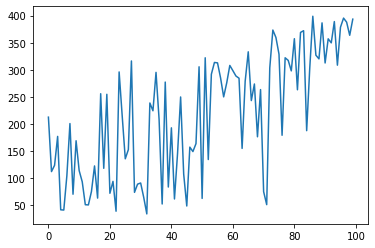

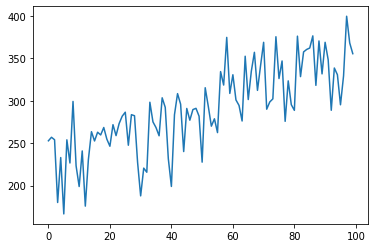

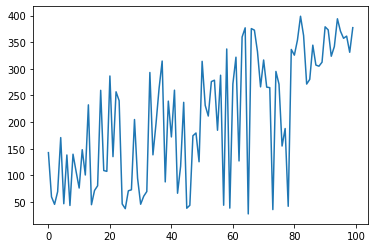

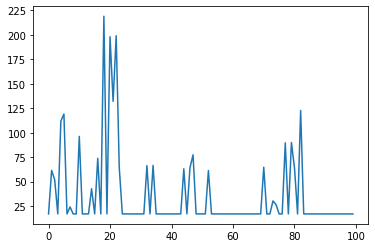

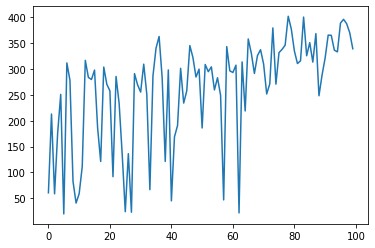

In [302]:
for iii in range(5):
    source = np.random.randint(0,25)
    target = np.random.randint(0,25)
    if source != target :
        iter_ = 100
        iter_actuel = 0
        current_iter = 0
        var_dict = {}
        max_move = 25
        cpt = 0

        expirience_replay = {}
        
        summ = 0

        for ii in range(iter_):
            iter_actuel = ii + 1
            current_node = source
            path = ""
            cpt = 0
            solve_var = []
            j = source

            Delay_df = pd.DataFrame(np.zeros((1,1)))
            for link in g.edges:
                s_link = str(link).strip('(').strip(')').replace(',','_').replace(' ','')
                Delay_df[s_link] = g.edges[link]['delay']

            flag_finished = False
            while flag_finished != True and cpt < max_move:
                j = get_action (current_node)
                i = current_node
                #print("current node : {}".format(i))
                #print("action taken : {}".format(j))
                if ((i,j) in get_possible_actions(i)):
                    #print("action taken")
                    Delay_df = new_iter_delay(Delay_df,j, 1)
                    path += "{}_".format(str((i,j)))
                    solve_var.append((i,j))
                    var_dict[i,j] = 1
                    current_node = j
                    cpt = cpt + 1
                    if j == target:
                        flag_finished = True
            path_ = path[:-1]
            solve_var = get_path_as_list_tuples(path_)

            sum_delay = 0
            cpt_solve_var = 0
            for link in solve_var:
                s_link = str(link).strip('(').strip(')').replace(',','_').replace(' ','')
                sum_delay = sum_delay + Delay_df.iloc[cpt_solve_var,Delay_df.columns.get_loc(s_link)]
                cpt_solve_var = cpt_solve_var +1

            ## Draw chosen path red ##
            #draw_path(solve_var)

            dict_res[ii]['Sum of delay'] = sum_delay
            give_final_reward(solve_var,dict_res[ii]['Sum of delay'])
    plot_graph('Sum of delay')
        

#plot_graph(summ/10)
#print("{} : {}".format(test,summ/10))


In [284]:
for ii in range(iter_):
    print(dict_res[ii]['Sum of delay'] )

163.06
69.03
141.44
145.67000000000002
29.18
34.53
28.28
31.299999999999997
76.44999999999999
205.9
45.25000000000001
67.35
46.35
27.979999999999997
70.08
30.32
119.61
89.06
29.689999999999998
29.39
85.1
60.67
29.64
30.53
89.33999999999999
99.04
54.510000000000005
93.55000000000001
239.44
29.499999999999996
30.57
30.919999999999998
74.39
29.1
42.46000000000001
105.98
60.25000000000001
110.7
80.38000000000001
29.17
91.88
31.02
49.32
91.92
177.07999999999998
54.91
72.42999999999999
85.91999999999999
41.86
30.509999999999998
59.4
30.2
83.65
144.25
83.08000000000001
81.02000000000001
124.07
240.37
235.67
29.6
86.80000000000001
113.07999999999998
46.70000000000001
107.80999999999999
74.6
65.86
203.68
27.5
186.39000000000001
193.42999999999998
142.01000000000002
257.93
46.36
34.620000000000005
28.619999999999997
29.68
37.34
130.57
56.980000000000004
27.64
87.03999999999999
29.02
28.619999999999997
178.30000000000004
29.53
30.299999999999997
30.28
133.47
185.26000000000002
139.23
537.79000000

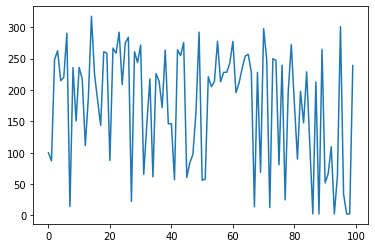

In [289]:
plot_graph('Sum of delay')

In [283]:
Delay_df

,0,0_4,0_9,1_8,1_23,2_10,3_18,4_3,4_24,5_4,...,21_8,22_1,22_3,22_4,22_10,22_19,23_12,23_24,24_5,24_8
0,0.0,18.54,1.00,14.22,4.07,18.38,14.66,11.16,10.91,5.79,...,18.73,15.08,12.01,17.62,1.08,8.64,17.60,3.66,2.70,8.92
0,1.0,17.47,2.65,13.96,4.63,20.00,15.94,12.95,11.88,5.90,...,17.60,15.60,13.08,16.72,1.79,7.75,18.19,2.62,2.55,9.13
0,2.0,18.21,1.18,15.17,6.13,18.21,14.75,13.19,11.11,7.39,...,16.89,15.28,12.84,16.13,0.56,6.70,18.09,0.93,3.34,8.21


In [278]:
sum_delay = 0
cpt_solve_var = 0
for link in solve_var:
    s_link = str(link).strip('(').strip(')').replace(',','_').replace(' ','')
    print(s_link)
    sum_delay = sum_delay + Delay_df.iloc[cpt_solve_var,Delay_df.columns.get_loc(s_link)]
    cpt_solve_var = cpt_solve_var +1

0_9
9_13
13_22
22_19
19_0
0_4
4_24
